# Black Level Subtraction

*Why Subtracting Black Level Is Important*

Subtracting the black level is a crucial first step in processing raw sensor data because it corrects for the electronic offset introduced by the camera’s sensor and readout electronics. Even when no light hits the sensor, the output signal is not zero due to this offset, known as the black level. If this offset is not removed, all subsequent pixel values will be artificially elevated, leading to inaccurate representation of shadows and dark regions in the image. This can result in a loss of true black, reduced contrast, and incorrect color interpretation, especially in low-light areas.

By subtracting the black level, you ensure that the pixel values start from a physically meaningful zero point, where zero corresponds to the absence of light. This correction is essential for all downstream image processing steps, such as white balance, demosaicing, and color correction, which assume that the input data is linearly related to the amount of light captured. Without black level subtraction, these operations can introduce artifacts, color shifts, and errors in tone mapping, ultimately degrading image quality.


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import rawpy

from dataset.hdrplus_downloader import HDRPlusDatasetDownloader
from phase_1.step_1_black_level_subtraction.black_level_subtraction import subtract_black_levels
from utils import get_exif_metadata, plot_images

%matplotlib inline
# Set the default figure format for inline matplotlib plots to JPEG for smaller file sizes and faster rendering
%config InlineBackend.figure_format = 'jpeg'
# Configure matplotlib to save figures with tight bounding boxes (removes extra whitespace)
%config InlineBackend.rc = {'savefig.bbox': 'tight'}


## 1. Downloading data

For this time we use the same folder from HDR+ dataset on Google Cloud.

In [8]:
downloader = HDRPlusDatasetDownloader()
source_path = Path("hdrplusdata/20171106_subset/bursts/0006_20160722_115157_431")
folder_path = downloader.download(source_path)

2026-01-20 20:32:42.672 | INFO     | dataset.hdrplus_downloader:download:55 - Destination path wasn't explicitly set. Downloading into `/Users/andreiaksionau/Developer/Computational_Photography/ISPFoundry/data/raw/hdrplus_dataset`
2026-01-20 20:32:42.674 | INFO     | dataset.hdrplus_downloader:download:61 - Folder already exists. Force download was disabled.


For this particular example let's take a look at the 5-th raw image in the burst.

In [11]:
dng_path = next(p for p in folder_path.iterdir() if p.match("payload_*004.dng"))
with rawpy.imread(str(dng_path)) as raw_obj:
    raw_image = raw_obj.raw_image.astype(np.float32)

In [12]:
metadata = get_exif_metadata(dng_path)[0]
print(f"Black level captured from metadata: {metadata['BlackLevel']}")
print(f"Min pixel value of the raw image: {raw_image.min()}")


Black level captured from metadata: 63.75 63.5 63.5 63.75
Min pixel value of the raw image: 59.0


The minimum value of the image is lower than any of the black levels, implying that the result, after subtraction, will contain negative values. We should **NOT** clamp values to zero prematurely.

*Why Preserve Negative Values?*

1. Statistical Accuracy
Read noise is approximately zero-mean. Clamping at zero destroys noise symmetry and biases the mean upward ($\mathbb{E}[n] > 0$). This results in “milky” shadows and inaccurate color shifts.

2. Denoising & Merging
Downstream algorithms (temporal merging, denoising) rely on accurate noise statistics. Preserving negatives enables these algorithms to correctly average noise back toward zero.

3. Radiometric Validity
Negative values in a linear pipeline are physically meaningful, representing statistical fluctuations below the average dark floor. 

**Rule of Thumb:** Keep negative values throughout the **linear** pipeline. Only clamp when transitioning to **non-linear** or perceptual stages (e.g., tone mapping or display).

In [13]:
raw_image_subtracted = subtract_black_levels(raw_image, metadata)

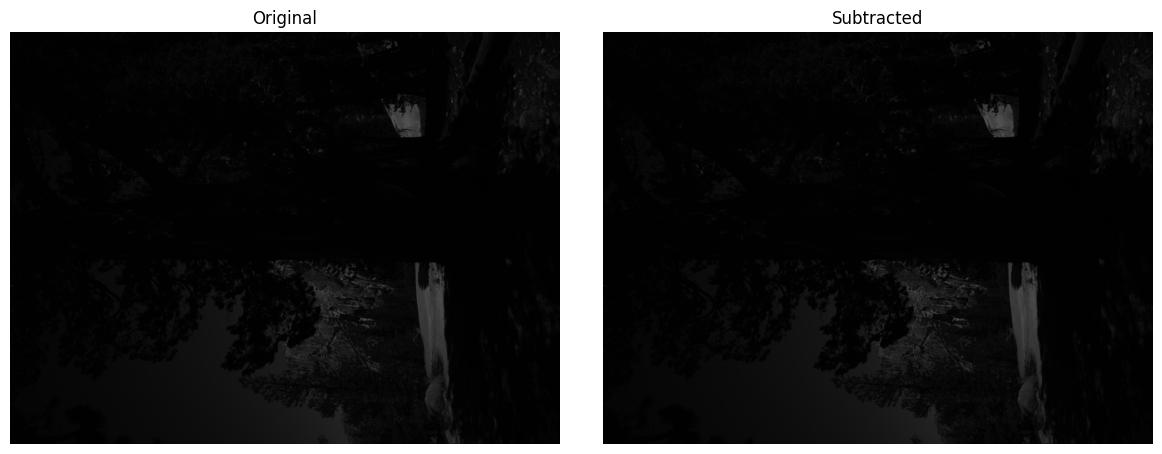

In [14]:
imgs = (raw_image, raw_image_subtracted)
titles = ("Original", "Subtracted")
plot_images(imgs, titles)

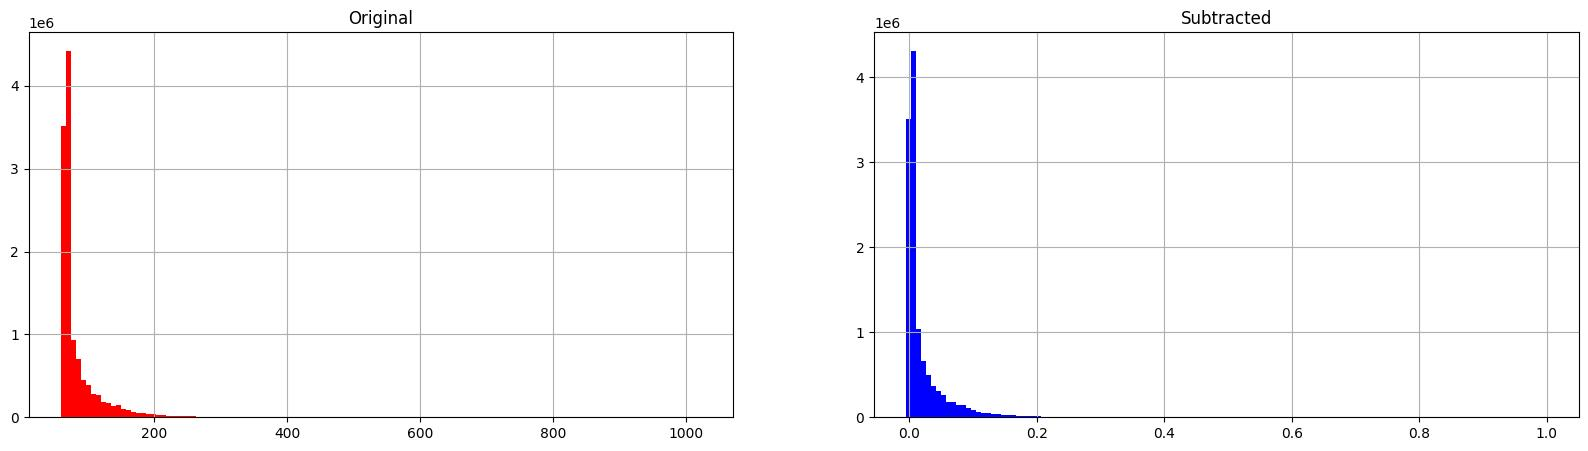

In [15]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flat

colors = ("red", "blue")

for data, title, color in zip(imgs, titles, colors):
    ax = next(axes)
    ax.set_title(title)
    ax.hist(data.ravel(), bins=128, color=color, label="Other")
    ax.grid()

plt.show()


As anticipated, the pixel distribution remained unchanged, but it was only shifted to the left. Consequently, the displayed image appears darker.